# Модель микроуровневого стресс-тестирования (на уровне отдельных компаний-застройщиков) - "Банкротства застройщиков"

#### Дополнительные блокноты для работы с этой моделью

  - <a href="bankrupt_prob_prepare.ipynb" target="_blank">Блокнот Jupyter для работы с промежуточными моделями и подготовки массива данных для основной модели</a>  
  - <a href="bankrupt_prob_DB.ipynb" target="_blank">Блокнот Jupyter для работы с базой данных для промежуточнымх моделей</a>


### Основная модель (вероятность банкротства для **отдельной** компании:       
<br>
 <center>$Y_i^j$ ~ $ROA\_{par}_{i-1}^j + Z\_A\_{par}_{i-1}^j + LOAN\_{par}_{i-1}^j + Ln(capital_i^j) + 1$</center>
 
 
где $ i - \text{индекс года};  j - \text{индекс компании} $
 
#### Предикторы:
- Ставка по кредитам для компании j ($LOAN\_{par}^j$ с лагом 1 год)
- Рентабельность застройщика j ($ROA\_{par}^j$ с лагом 1 год)
- Чистая кредиторская задолженность компании j ($Z_A\_{par}^j$ с лагом 1 год)
- Уставной капитал компании j, $ln$ ($capital^j$)

#### Объясняемая переменная:
- флаг банкротства компании j, устанавливаемый в год банкротства ($Y^j$ = 1 означает, что компания - банкрот)

#### Параметры:
- Переменная `fBnkrp_Level` задает порог отсечки события (превышение порога - предприятие банкрот).
- `iLastFactYEAR` - последний год фактических данных. Выбирается максимальный год из таблицы SPARK.
- `iLastFORCAST` - год горизонта прогноза. Устанавливается $iLastFORCAST = iLastFactYEAR + 3$ но можно задать вручную. 
 
**Модель оценивается на фактических значениях**

In [15]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlalchemy as sa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import patsy
import datetime as dt

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('..', 'DB', 'bankrp.sqlite3')

# константы базы данных SQLite3
strSRC_data='model_data' # название таблицы с исходными данными для модели
# ------------

iLastFactYEAR=conWork.connect().execute('select max(year) from spark').fetchone()[0]
iLastFORCAST=iLastFactYEAR+3
fBnkrp_Level=7e-3
print('Последний фактический год - ', iLastFactYEAR, '; горизонт прогноза - ', iLastFORCAST, 'отсечка - ', fBnkrp_Level)

Последний фактический год -  2019 ; горизонт прогноза -  2022 отсечка -  0.007


## Подготовка данных
 
Исходные данные для модели - в таблице `model_data` базы данных. 
В этой таблице предикторы модели продлены на прогнозный период при помощи данных, полученных от промежуточных моделей (экстраполяция).   

In [25]:
conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных

strSelectDATA='select * from {}'.format(strSRC_data)

pdf_Data=pd.read_sql(strSelectDATA, con=conWork).set_index(['inn', 'year'])
pdf_Data.to_csv('text_model_data.csv', sep=';', encoding='cp1251', decimal=',')

<div class="alert alert-block alert-info">
    <b>
    X - предикторы фактических значений<br>
    Y - известные объясняемые значения<br>
        <hr>
    x - предикторы прогнозных значений<br>
    y - прогнозные объясняемые значения<br>
        <br>
    Прогнозные значения вероятностей банкротств считаются на основе, но не по регрессионной модели - см. ниже
    </b>
    
</div>

In [23]:
pdf_XY=pdf_Data.loc[idx[:, :iLastFactYEAR], :]
pdf_xy=pdf_Data.loc[idx[:, iLastFactYEAR+1:iLastFORCAST], :]
pdf_XY.to_csv('src_data.csv', sep=';', encoding='cp1251', decimal=',')

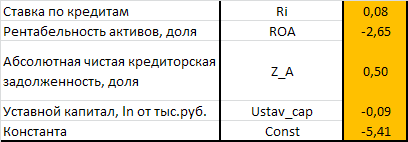

### Оценка регрессионой модели

In [22]:
bnkr_model = smf.logit("Y ~ ROA_par.shift(1) + Z_A_par.shift(1) + LOAN_par.shift(1) + np.log(capital)", data=pdf_XY)
bnkr_result = bnkr_model.fit()

print(bnkr_result.summary())

Optimization terminated successfully.
         Current function value: 0.033765
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                27593
Model:                          Logit   Df Residuals:                    27588
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:               0.0001387
Time:                        19:57:10   Log-Likelihood:                -931.66
converged:                       True   LL-Null:                       -931.79
Covariance Type:            nonrobust   LLR p-value:                    0.9923
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -5.2809      0.489    -10.801      0.000      -6.239      -4.323
ROA_par

# Прогноз вероятностей банкротств компаний
<br>
Вероятность банкротства j-ой компании в i-м году равна:    
<br><br>    
<center> $p_i^j=A \cdot r_{i-1}^j+ B \cdot ROA\_{par}_{i-1}^j+C \cdot Z\_A\_{par}_{i-1}^j+C \cdot Ln(capital_i)+Intercept$ </center>

где 
- $А, В, С$ и $Intercept$ - коэффициенты регрессии;  
- $ ROA\_{par}_{i-1}^j, Z\_A\_{par}_{i-1}^j, capital_i - \text {roa, z_a и уставной капитал j-ой компании}$
- $ r_{i-1}^j $ - индивидуальная кредитная ставка j-ой компании, считается по формуле:

<center> $ r_i^j=LOAN\_{par}_i^j+ φ \cdot \overline{P_{i+1}} \cdot (1-γ) \cdot 100 $ </center>   

    где   
- $ LOAN\_{par}_i^j $ - модельная кредитная ставка i-го года (фактически это $ LOAN\_{par}_i $ - одинаковая для всех компаний i-го года);   
- $ \overline{P_{i+1}} $ - медианая вероятность банкроств для $(i+1)$ -го года (в перспективе переход на $ p_{i+1}^j$ - для компании);
- $φ$ – параметр риск-премии для строительного сектора (по умолчанию = 5,22; возможно задание пользователем);
- $γ$ – гарантии (доля кредитов компании, обеспеченных гарантиями):
<br>
  $
\begin{equation*}
γ =  
 \begin{cases}
   β \cdot λ &\text{ если } \dfrac{ROA\_{par}_i^j + ROA\_{par}_{i-1}^j + ROA\_{par}_{i-2}^j}{3}<α \\
   \dfrac{(β-(1-x) \cdot β \cdot λ)}{x} &\text{ если } \dfrac{ROA\_{par}_i^j + ROA\_{par}_{i-1}^j + ROA\_{par}_{i-2}^j}{3}>=α
 \end{cases}
\end{equation*}
$    

      где 
    - α – параметр разделения компаний на группы по уровню рентабельности (по умолчанию = 0)
    - β – параметр доли гарантий в общем объеме запрашиваемых кредитов в среднем по отрасли строительных компаний (по умолчанию = 0,3)
    - λ –параметр жесткости решения о выдаче гарантий (1 - мягкий, гарантии предоставляются всем компаниям; 0 - очень жесткий, гарантии предоставляются только рентабельным компаниям; прочие значения - доля гарантий для нерентабельных компаний), по умолчанию = 1
    - x – доля кредитов  (в общем объеме кредитов) у компаний с рентабельностью выше уровня α

 

In [20]:
bnkr_result.params['ROA_par.shift(1)']

Intercept           -5.280902
ROA_par.shift(1)    -0.015436
Z_A_par.shift(1)    -0.002475
LOAN_par.shift(1)    0.001344
np.log(capital)      0.004640
dtype: float64

In [ ]:
bnkr_model

#### Алгоритм счета:
Значения $ROA\_{par}^j, Z\_A\_{par}^j$ и $capital^j$ для всех компаний расчитаны в блокноте <a href="bankrupt_prob_DB.ipynb" target="_blank">"Расчет промежуточных моделей"</a> и беруться из базы данных (таблица model_data).   
Значения кредитной ставки $LOAN\_{par}^j$ на фактичском периоде так же беруться из базы данных (таблица model_data) - на этом периоде они обинаковы для всех компаний.

**По этим значениям, на фактических данных оценивается модель**

Далее, на прогнозном интервале предиктор `кредитная ставка для компании j` $r_i^j$ расчитывается так:
<br>
<center>$r_i^j = LOAN\_{par}_i^j+ φ*P\_(t+1)*(1-γ)*100$</center>

где 

<div style="background:AntiqueWhite">
 <h2> Оценка и расчет основной модели "Банкротства застройщиков"</h2>
 <br>
 <center>$Y$ ~ $ROA_{y-1} + Z\_A_{y-1} + LOAN_{y-1} + Ln(capital) + 1$</center>

 <b>Предикторы:</b>
 <ul>
 <li>Ставка по кредитам (<i>LOAN</i> с лагом 1 год)</li>
 <li>Рентабельность застройщика (<i>ROA</i> с лагом 1 год)</li>
 <li>Чистая кредиторская задолженность(<i>Z_A</i> с лагом 1 год)</li>
 <li>Уставной капитал, ln от тыс.руб.(<i>capital</i>)</li>
 </ul><br>
 <b>Объясняемая переменная</b> - флаг банкротства компании, устанавливаемый в год банкротства (<i>Y</i>)
 <br><br>
 Переменная <b>fBnkrp_Level</b> задает порог отсечки события (превышение порога - предприятие банкрот).
</div>

In [5]:
# bnkr_model = sm.GLM.from_formula("Y ~ ROA_ + Z_A_ + np.log(capital)", family=sm.families.Binomial(), data=pdf_X)
bnkr_model = smf.logit("Y ~ roa + z_a + np.log(capital)", data=pdf_XY)
bnkr_result = bnkr_model.fit()

print(bnkr_result.summary())

Optimization terminated successfully.
         Current function value: 0.077981
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                47147
Model:                          Logit   Df Residuals:                    47143
Method:                           MLE   Df Model:                            3
Date:                Wed, 16 Sep 2020   Pseudo R-squ.:                0.005295
Time:                        18:15:31   Log-Likelihood:                -3676.6
converged:                       True   LL-Null:                       -3696.2
Covariance Type:            nonrobust   LLR p-value:                 1.618e-08
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.5096      0.137    -25.560      0.000      -3.779      -3.240
roa           

In [6]:
pdf_XY['Y_p']=bnkr_result.predict()
pdf_XY

ValueError: Length of values (47147) does not match length of index (80954)

## Оценка и расчет основной модели "Банкротства застройщиков"
<br>
<center>$Y$ ~ $\overline{ROA}_{y-1} + \overline{Z\_A}_{y-1} + \overline{LOAN}_{y-1} + Ln(capital) + 1$</center>


<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Ставка по кредитам (<i>LOAN_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>
        <li>Медианная по отрасли рентабельность застройщика (<i>ROA_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>
        <li>Медианная по отрасли Чистая кредиторская задолженность(<i>Z_A_</i> датафрейма <i>pdfSubModResult</i> с лагом 1 год)</li>        
        <li>Уставной капитал, ln от тыс.руб.(<i>Capital</i> датафрейма <i>pdfSPARK</i>)</li>
    </ul><br>
    <b>Объясняемая переменная</b> - год банкротства компании (<i>Cancel_date</i> датафрейма <i>pdfSPARK</i>, ненулевая дата соответствует событию "банкротство")<br><br>
    Переменная <b>fBnkrp_Level</b> задает порог отсечки события (превышение порога - предприятие банкрот).
</div>

Для прогноза данные датафрейма `pdfSPARK` продлеваются (копируются построчно) на прогнозные года (данные беруться из последнего, максимального для всех записей года. 

Потом полученный датафрейм комбинируется с датафреймом `pdfSubModResult`  
При совпадении значений в полях `year` и года в `Cancel_date` в поле `Cancel_date` ставится `1` - индикатор события. Последующие года для даного `inn` в моделированиине участвуют - компания считается банкротом

<div class="alert alert-block alert-danger">
    <b>Надо бы еще сделать отсечку: если есть (либо фактическая, либо модельная) дата ликвидации, то для даной компании все строки, с датой больше даты ликвидации - удалить. То есть удалить все, что после банкротства</b>
    <br>
    <b>Еще наверное надо сделать прогноз (расчет y) - прогонять по годам. 2020, потом 2021 и т.д. И удалять всех банкротов из последующих годов.</b>
</div>

#### Строим модель банкротств



In [168]:
import statsmodels.formula.api as smf

# bnkr_model = sm.GLM.from_formula("Y ~ ROA_ + Z_A_ + np.log(capital)", family=sm.families.Binomial(), data=pdf_X)
bnkr_model = smf.logit("Y ~ ROA_ + Z_A_ + np.log(capital)", data=pdf_X)
bnkr_result = bnkr_model.fit()

print(bnkr_result.summary())

         Current function value: 0.046314
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                66862
Model:                          Logit   Df Residuals:                    66858
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Aug 2020   Pseudo R-squ.:                 0.05689
Time:                        19:39:00   Log-Likelihood:                -3096.7
converged:                      False   LL-Null:                       -3283.5
Covariance Type:            nonrobust   LLR p-value:                 1.153e-80
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -33.6472      3.115    -10.803      0.000     -39.752     -27.543
ROA_            -1937.0313    187.005    -10.358  

#### Проверка по историческим данным

Если в некотором годе вероятность банкротства по модели больше заданного уровня (`fBnkrp_Level`), компания считается банкротом (флаг Y_p устанавливается в 1)

In [169]:
pdf_X['Y_p']=(bnkr_result.predict(pdf_X)>=fBnkrp_Level).astype(int)
pdf_X

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
13,7701651356,2008,NaT,0.005350,0.174666,50000.0,0.0,0
15,7725038614,2008,NaT,0.005350,0.174666,12000.0,0.0,0
17,7714726658,2008,2020-07-21,0.005350,0.174666,10000.0,0.0,0
18,7807020417,2008,NaT,0.005350,0.174666,110000.0,0.0,0
20,7703037783,2008,NaT,0.005350,0.174666,4000.0,0.0,0
...,...,...,...,...,...,...,...,...
112627,6213013559,2020,NaT,0.002941,0.209570,80000000.0,0.0,0
112628,2221204292,2020,NaT,0.002941,0.209570,80000000.0,0.0,0
112629,7017342291,2020,NaT,0.002941,0.209570,50284000.0,0.0,0
112630,5603041609,2020,NaT,0.002941,0.209570,10000.0,0.0,1


#### Прогноза банкротств на заданный горизонт

In [170]:
i_start=dt.datetime.now().year
i_horizont=i_start+3

# bnkr_result.predict()
pdf_x['Y_p']=(bnkr_result.predict(pdf_x)>=fBnkrp_Level).astype(int)
pdf_x


,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
112653,3905610382,2021,2019-12-17,0.005940,0.191393,10000.0,0.0,0
112692,5530005074,2021,2020-03-23,0.005940,0.191393,10000.0,0.0,0
112718,5503031981,2021,2019-12-18,0.005940,0.191393,10000.0,0.0,0
112745,7723186303,2021,2020-07-02,0.005940,0.191393,10000.0,0.0,0
112767,7722535569,2021,2018-12-27,0.005940,0.191393,10000.0,0.0,0
...,...,...,...,...,...,...,...,...
155878,0816006455,2025,2020-01-28,0.005477,0.187667,10000.0,0.0,0
155879,7424031171,2025,2019-12-27,0.005477,0.187667,10000.0,0.0,0
155883,6140038767,2025,2020-04-30,0.005477,0.187667,20000.0,0.0,0
155938,7604068205,2025,2019-04-02,0.005477,0.187667,10000.0,0.0,0


In [171]:
pdf_x.loc[pdf_x['Y_p']==1]

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p


In [172]:

pdf_X.loc[(pdf_X['Y']!=0) & (pdf_X['Y_p']!=pdf_X['Y'])]

,inn,year,Cancel_date,ROA_,Z_A_,capital,Y,Y_p
38814,2722057514,2012,2012-06-21,0.003000,0.196358,10000.0,1.0,0
63996,2012002172,2015,2015-07-13,0.001400,0.191316,12010000.0,1.0,0
65335,2315143895,2015,2015-09-17,0.001400,0.191316,100000.0,1.0,0
68678,6228040280,2015,2015-09-03,0.001400,0.191316,10200000.0,1.0,0
69790,6901024343,2016,2016-12-27,0.001100,0.190117,30678000.0,1.0,0
...,...,...,...,...,...,...,...,...
111893,8911001194,2020,2020-03-05,0.002941,0.209570,7609000.0,1.0,0
111950,5836662951,2020,2020-06-16,0.002941,0.209570,80000000.0,1.0,0
112318,6685010079,2020,2020-06-30,0.002941,0.209570,81500000.0,1.0,0
112534,6673150882,2020,2020-05-13,0.002941,0.209570,931370000.0,1.0,0


# Ниже - пробы

Можно строить регрессию по заданой формуле, не обязательно линейную, можно использовать любую питоновскюй функции, или встроенные, типа сплайнов

In [16]:
import patsy
import statsmodels.formula.api as smf

# resROA = sm.OLS(Y_roa, X_roa, missing='drop').fit()

# resROA.summary()

pdf=pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy()
pdf['ROA']=Y_roa

resROA_f = sm.OLS.from_formula(formula='ROA ~ I_nom_prices_sec_market + marga', missing='drop', data=pdf).fit()

resROA_f.summary()

/home/egor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.9513
Date:                Tue, 28 Jul 2020   Prob (F-statistic):              0.426
Time:                        19:38:20   Log-Likelihood:                 60.121
No. Observations:                  11   AIC:                            -114.2
Df Residuals:                       8   BIC:                            -113.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0122      0.010     -1.182      0.271      -0.036       0.012
I_nom_prices_sec_market     0.0080      0.007      1.211      0.261      -0.007       0.023
marga                       0.0049      0.004      1.106      0.301      -0.005       0.015
==============================================================================
Omnibus:                        0.481   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.424
Skew:                           0.377   Prob(JB):                        0.809
Kurtosis:                       2.404   Cond. No.                         65.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# pdfSPARK=pdfSPARK.loc[pdfSPARK[['capital', 'Cancel_date', 'ROA', 'Z_A']].dropna(how='all').index, :]
# pdfM=pdfSPARK.merge(pdfNoza, on='inn')
# pdfM.loc[pdfM['inn']=='5050102110']

In [ ]:
# pdfSPARK.loc[pdfSPARK['inn']=='6232001460']

In [ ]:
# pdfT=pd.read_sql('select * from spark', con=conWork)
# pdfT.loc[(pdfT['inn']=='6232001460')]

In [ ]:

# res.loc[idx[2015:2019, :], idx[:]]

<div class="alert alert-block alert-info">
<b>Для изменения данных в ручном режиме использовать шаблон</b>

</div>

```python
pdfXLS_model.loc[2010, 'I_nom_prices_sec_market'] = 0
```

pdfXLS_model.loc[<год>, <название нужной колонки или список колонок>] = <нужное значение или список значений>

In [ ]:
pdf['const']=1.0
model_indep = sm.GEE.from_formula(
    "rent_otr ~ marga + i_price",
    cov_struct = sm.cov_struct.Independence(),
    groups = 'const',
    data=pdf.reset_index()
    ).fit()
model_indep.summary()

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Store the url string that hosts our .csv file
# url = "Cartwheeldata.csv"

# Read the .csv file and store it as a pandas Data Frame
# df = pd.read_csv(url)

# Create Scatterplot
sns.lmplot(x='marga', y='i_price', data=pdf)

plt.show()

In [ ]:
# Scatterplot arguments
# sns.lmplot(x='Wingspan', y='CWDistance', data=df,
#            fit_reg=False, # No regression line
#            hue='Gender')   # Color by evolution stage

# plt.show()